# Google drive mount

In [75]:
# 계정 드라이브와 마운트하기
# 모두 선택해서 동의해야 마운트가 오류없이 됩니다.
# from google.colab import drive
# drive.mount('/content/drive')

# 파일 가져오기

In [76]:
# !ls /content/drive/MyDrive/Kaggle01

In [77]:
# !unzip /content/drive/MyDrive/Kaggle01/rokey-boot-camp-mini-competition.zip -d data

In [78]:
# !ls data

# 파일 구조 확인

In [79]:
# !ls data/train_data

In [80]:
# !ls data/test_data

In [81]:
# 첫 10개의 학습 데이터 이름과 label 출력
# import pandas as pd
# train_df = pd.read_csv("~/Desktop/AI_project01_data/data/train_data.csv")
# train_df.head(10)

In [82]:
# # 각 파일마다 라벨이 무엇인지 나타내는 dictionary 생성
# name2label = dict(zip(train_df["name"], train_df["label"]))
# print(name2label['03501.png'])

# # glob 라이브러리로 훈련데이터에 있는 파일 리스트 출력
# import os
# data_path = "/home/kim/Desktop/AI_project01_data/data"
# from glob import glob
# # glob(f"{data_path}/train_data/*.png")

# DataLoader

압축푼 직후에는 파일적용이 되지 않아 FileNotFoundError 오류가 뜰 수 있습니다.

그러한 경우 약간의 대기 시간 이후 다시 실행하면 됩니다.

In [83]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score,
    f1_score
)

# 한글 폰트 및 그래프 스타일 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(f"PyTorch 버전: {torch.__version__}")
print(f"NumPy 버전: {np.__version__}")

PyTorch 버전: 2.9.1+cu130
NumPy 버전: 2.2.6


In [84]:
# 랜덤성 제어를 위한 seed 고정
import random
import numpy as np
import torch

seed = 0
deterministic = True

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
if deterministic:
	torch.backends.cudnn.deterministic = True
	torch.backends.cudnn.benchmark = False

In [85]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, Subset
import torchvision.transforms as transforms
from torchvision.transforms import v2

from PIL import Image
from tqdm import tqdm
import pandas as pd

In [86]:
from glob import glob

# 커스텀 데이터셋 클래스
class MyDataset(Dataset):
    def __init__(self, data_path, transform=None, train=True):
        self.train = train
        train_df = pd.read_csv(f"{data_path}/train_data.csv")

        self.name2label = dict(zip(train_df["name"], train_df["label"]))

        self.classes = {
            0: 'airplane',
            1: 'bird',
            2: 'car',
            3: 'cat',
            4: 'deer',
            5: 'dog',
            6: 'horse',
            7: 'monkey',
            8: 'ship',
            9: 'truck'
        }

        if self.train:
            self.img_path = glob(f"{data_path}/train_data/*.png")
            self.labels =  [self.name2label[d.split("/")[-1]] for d in self.img_path]
        else:
            self.img_path = glob(f"{data_path}/test_data/*.png")

        self.transform = transform

    def __len__(self):
        return len(self.img_path)   

    def __getitem__(self, index):
        img = Image.open(self.img_path[index])
        if img.mode != 'RGB':
            img = img.convert('RGB')

        if self.transform:
            img = self.transform(img)

        if self.train:
            return img, self.labels[index]
        else:
            return img, self.img_path[index].split("/")[-1]

In [87]:
# 데이터셋 디렉토리 위치 지정
data_path = "/home/kim/Desktop/AI_project01_data/data"

In [88]:
'''
데이터 전처리
    - transform.Compose에 전처리할 순서를 차례로 지정한 후 리스트 형태로 입력하여 데이터 생성시 설정한 전처리를 적용
    - 여러 가지의 데이터 증강 기법이 들어감
'''
transform =  transforms.Compose([
    # To-do: 증강 기법 적용
    # v2.RandomRotation(degrees=15), # -15도에서 +15도 사이의 각도로 회전
    transforms.RandomCrop(96, padding=4),
    v2.RandomHorizontalFlip(), # 수평 뒤집기
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    v2.ToTensor(),
    v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

test_transform =  transforms.Compose([
    v2.ToTensor(),
    v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

train_base = MyDataset(data_path, train=True, transform=transform)      # 증강 O
val_base   = MyDataset(data_path, train=True, transform=test_transform) # 증강 X (Clean)

# 3. 인덱스 나누기
# 데이터셋의 길이를 구해서 인덱스만 나눕니다.
dataset_size = len(train_base)
train_size = int(dataset_size * 0.9)
val_size = dataset_size - train_size

# random_split을 사용해 '인덱스'를 얻어냅니다.
# generator를 고정해야 실행할 때마다 데이터가 섞이는 방식이 일정합니다.
generator = torch.Generator()
train_subset, val_subset = torch.utils.data.random_split(
    range(dataset_size), [train_size, val_size], generator=generator
)

# 4. Subset을 이용해 최종 데이터셋 완성
# train_subset의 인덱스는 -> 증강이 적용된 train_base에서 가져오고
# val_subset의 인덱스는   -> 증강이 없는 val_base에서 가져옵니다.
train_data = Subset(train_base, train_subset.indices)
val_data   = Subset(val_base, val_subset.indices)

test_data = MyDataset(data_path, train=False, transform=test_transform)
print(f"Split 후 train_data 크기: {len(train_data)}, val_data 크기: {len(val_data)}")

train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)

Split 후 train_data 크기: 4500, val_data 크기: 500


/home/kim/miniconda3/envs/yolo_env/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


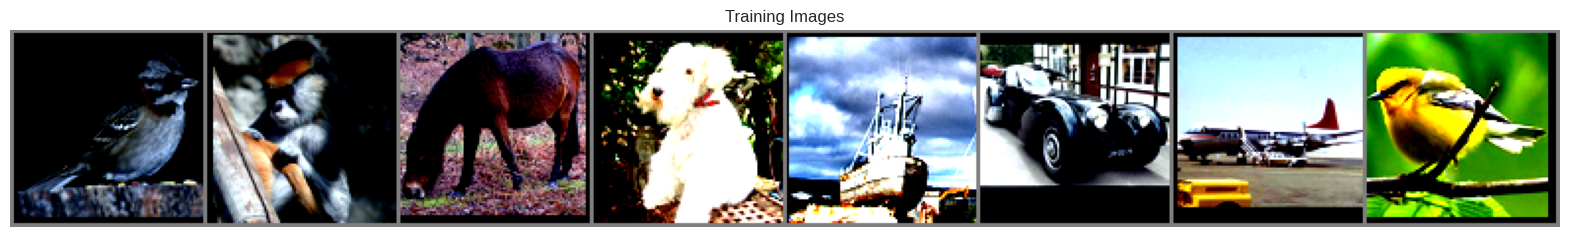

Labels: ['bird', 'monkey', 'horse', 'dog', 'ship', 'car', 'airplane', 'bird']


In [89]:
import matplotlib.pyplot as plt
import numpy as np

# 시각화용 역정규화 함수 (Normalize를 다시 되돌림)
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# train_loader에서 배치를 하나 뽑아봅니다.
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 이미지 출력 (격자로 보기)

import torchvision
plt.figure(figsize=(20, 15))
plt.title('Training Images')
plt.grid(False)
plt.axis('off')

imshow(torchvision.utils.make_grid(images[:8], padding=2))
print('Labels:', [train_data.dataset.classes[l.item()] for l in labels[:8]])

In [90]:
# # ✅ 최신 방식
# from torchvision.models import ResNet18_Weights
# from torchvision.models import resnet18

# # 'DEFAULT'를 쓰면 현재 시점에서 가장 성능이 좋은 가중치를 자동으로 가져옵니다.
# model = resnet18(weights=ResNet18_Weights.DEFAULT)

# Model

In [91]:
# from torchinfo import summary
# model = CNN_v4(num_classes=10)
# summary(model, (100, 3, 96, 96), depth=1)

In [92]:
# import torch
# import torch.nn as nn
# import types
# from torchvision import models

# def set_dropout_to_resnet(model):
#     """
#     기존 ResNet 모델의 Layer 2, 3, 4에 
#     각각 0.1, 0.2, 0.3의 Dropout을 주입하는 함수
#     """
#     config = {
#         'layer2': 0.2,
#         'layer3': 0.3,
#         'layer4': 0.4
#     }

#     def new_forward(self, x):
#         identity = x
#         out = self.conv1(x)
#         out = self.bn1(out)
#         out = self.relu(out)
        
#         out = self.dropout(out)  # Dropout 적용
        
#         out = self.conv2(out)
#         out = self.bn2(out)

#         if self.downsample is not None:
#             identity = self.downsample(x)

#         out += identity
#         out = self.relu(out)
#         return out

#     for layer_name, p in config.items():
#         layer = getattr(model, layer_name)
#         for block in layer:
#             block.add_module('dropout', nn.Dropout(p=p))
#             block.forward = types.MethodType(new_forward, block)
            
#     return model

# # ========================================================
# # 1. 모델 생성 (Pretrained=False)
# # ========================================================
# # 최신 torchvision 버전 권장: weights=None
# # 구버전 호환: pretrained=False
# model = models.resnet18(pretrained=False) 

# # 2. Dropout 주입
# model = set_dropout_to_resnet(model)

# # 3. (선택사항) 첫 번째 Conv 레이어 수정이 필요하다면 여기서 진행
# # 예: 입력 채널이 3이 아닌 경우 등
# # model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# print("✅ 초기화된 ResNet에 Dropout 적용 완료")

In [93]:
# import torch.nn as nn
# from torchvision import models

# # 1. 모델 불러오기 (예: ResNet18)
# model = models.resnet18(pretrained=False)

# # 2. 기존 FC 레이어의 입력 채널 수 확인
# num_ftrs = model.fc.in_features
# num_classes = 10  # 예: 분류할 클래스 개수

# # 3. FC 레이어를 [Dropout + Linear]로 교체
# model.fc = nn.Sequential(
#     nn.Dropout(p=0.5),  # 50% 확률로 노드 끄기
#     nn.Linear(num_ftrs, num_classes)
# )

# print(model.fc)
# # 출력: Sequential(
# #   (0): Dropout(p=0.5, inplace=False)
# #   (1): Linear(in_features=512, out_features=10, bias=True)
# # )

In [94]:
def get_stl10_model():
    import torchvision.models as models
    model = models.resnet18(weights=None)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(num_ftrs, 10)
    )
    return model

In [95]:
from torchvision import models

# # Torchvision 라이브러리에서 모델 불러오기
# model = models.resnet18(pretrained=False)
# model = models.vgg19_bn(pretrained=False)
model = get_stl10_model()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [96]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n총 파라미터 수: {total_params:,}")
print(f"학습 가능한 파라미터 수: {trainable_params:,}")


총 파라미터 수: 11,173,962
학습 가능한 파라미터 수: 11,173,962


In [97]:
# 손실 함수
criterion = nn.CrossEntropyLoss()

# 옵티마이저: Adam
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

# 학습률 스케줄러: 검증 손실이 개선되지 않으면 학습률 감소
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',           # 손실을 최소화
    factor=0.5,           # 학습률을 0.5배로 감소
    patience=10,          # 10 에포크 동안 개선 없으면 감소
)

print(f"손실 함수: {criterion}")
print(f"옵티마이저: {optimizer.__class__.__name__}")
print(f"초기 학습률: {learning_rate}")
print(f"학습률 스케줄러: ReduceLROnPlateau")

손실 함수: CrossEntropyLoss()
옵티마이저: Adam
초기 학습률: 0.001
학습률 스케줄러: ReduceLROnPlateau


In [98]:
def evaluate(model, data_loader, criterion, device):
    """
    모델 평가 함수

    Returns:
        tuple: (loss, accuracy, predictions)
    """
    model.eval()

    running_loss = 0.0
    correct = 0
    total = 0
    
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    avg_loss = running_loss / total

    return avg_loss, accuracy, all_predictions, all_labels

In [99]:
def train_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, scheduler, device,
                               num_epochs=200, patience=30, print_interval=20):
    import copy
    """
    Early Stopping을 포함한 학습 함수

    Args:
        model: 학습할 모델
        train_loader: 훈련 데이터 로더
        val_loader: 검증 데이터 로더
        criterion: 손실 함수
        optimizer: 최적화 알고리즘
        scheduler: 학습률 스케줄러
        device: 학습 장치 (CPU 또는 GPU)
        num_epochs: 최대 에포크 수
        patience: Early Stopping을 위한 인내 에포크
        print_interval: 출력 간격

    Returns:
        dict: 학습 이력
    """
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    print("\n" + "=" * 90)
    print(f"{'Epoch':^8} | {'Train Loss':^12} | {'Train Acc':^10} | {'Val Loss':^12} | {'Val Acc':^10} | {'Status':^12}")
    print("=" * 90)

    for epoch in range(num_epochs):
        # 학습 단계
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # 통계 업데이트(배치 단위)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        # 에포크 단위 손실 및 정확도 계산
        train_loss = running_loss / total_train
        train_acc = correct_train / total_train

        # 평가 단계
        model.eval()
        val_running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        val_loss = val_running_loss / total_val
        val_acc = correct_val / total_val

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        val_accs.append(val_acc)

        # 학습률 스케줄러 업데이트
        if scheduler is not None:
            if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss) # val_loss
            else:
                scheduler.step()

        # Early Stopping 체크
        status = ""
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            
            best_model_state = copy.deepcopy(model.state_dict())
            status = "✓ Best"
        else:
            epochs_no_improve += 1
            status = f"({epochs_no_improve}/{patience})"

        # 출력
        if (epoch + 1) % print_interval == 0 or epoch == 0:
            print(f"{epoch+1:^8} | {train_loss:^12.4f} | {train_acc:^10.4f} | {val_loss:^12.4f} | {val_acc:^10.4f} | {status:^12}")

        # Early Stopping
        if epochs_no_improve >= patience:
            print("=" * 90)
            print(f"Early Stopping at Epoch {epoch+1}")
            print(f"Best validation loss: {best_val_loss:.4f}")
            break

    print("=" * 90)
    print("학습 완료!")

    # 최고 성능 모델 복원
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"최고 성능 모델로 복원 (검증 손실: {best_val_loss:.4f})")

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs
    }

# train_with_early_stopping(model, train_loader, val_loader, criterion, optimizer,
#                               scheduler, device,
#                               num_epochs=300, patience=30, print_interval=20)
# 모델 학습
history = train_with_early_stopping(
    model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=200,
    patience=30,
    print_interval=20
)


 Epoch   |  Train Loss  | Train Acc  |   Val Loss   |  Val Acc   |    Status   
   1     |    1.9619    |   0.2582   |    2.0868    |   0.2980   |    ✓ Best   
   20    |    0.8323    |   0.7044   |    1.0857    |   0.6080   |    ✓ Best   
   40    |    0.4215    |   0.8542   |    0.7280    |   0.7420   |    (1/30)   
   60    |    0.1378    |   0.9567   |    0.8550    |   0.7540   |   (21/30)   
   80    |    0.0330    |   0.9944   |    0.7171    |   0.7860   |   (17/30)   
Early Stopping at Epoch 93
Best validation loss: 0.6659
학습 완료!
최고 성능 모델로 복원 (검증 손실: 0.6659)


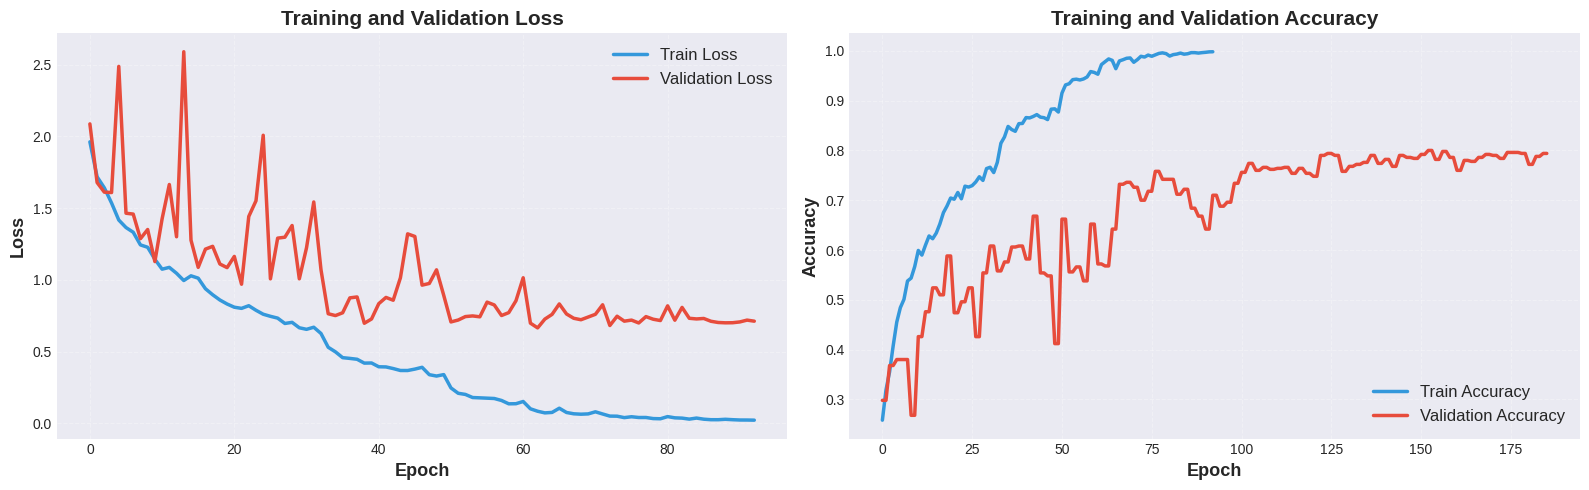

In [100]:
def plot_history(history):
    """
    학습 이력 시각화
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    # Loss 그래프
    axes[0].plot(history['train_losses'], label='Train Loss', linewidth=2.5, color='#3498db')
    axes[0].plot(history['val_losses'], label='Validation Loss', linewidth=2.5, color='#e74c3c')
    axes[0].set_xlabel('Epoch', fontsize=13, fontweight='bold')
    axes[0].set_ylabel('Loss', fontsize=13, fontweight='bold')
    axes[0].set_title('Training and Validation Loss', fontsize=15, fontweight='bold')
    axes[0].legend(fontsize=12, loc='upper right')
    axes[0].grid(True, alpha=0.3, linestyle='--')

    # Accuracy 그래프
    axes[1].plot(history['train_accs'], label='Train Accuracy', linewidth=2.5, color='#3498db')
    axes[1].plot(history['val_accs'], label='Validation Accuracy', linewidth=2.5, color='#e74c3c')
    axes[1].set_xlabel('Epoch', fontsize=13, fontweight='bold')
    axes[1].set_ylabel('Accuracy', fontsize=13, fontweight='bold')
    axes[1].set_title('Training and Validation Accuracy', fontsize=15, fontweight='bold')
    axes[1].legend(fontsize=12, loc='lower right')
    axes[1].grid(True, alpha=0.3, linestyle='--')

    plt.tight_layout()
    plt.show()

# 시각화
plot_history(history)

In [101]:
# 테스트 평가
test_loss, test_acc, test_predictions, test_labels = evaluate(model, val_loader, criterion, device)

print("\n" + "=" * 60)
print("최종 테스트 결과")
print("=" * 60)
print(f"테스트 손실: {test_loss:.4f}")
print(f"테스트 정확도: {test_acc:.4f} ({test_acc*100:.2f}%)")
print("=" * 60)


최종 테스트 결과
테스트 손실: 0.0000
테스트 정확도: 0.7940 (79.40%)


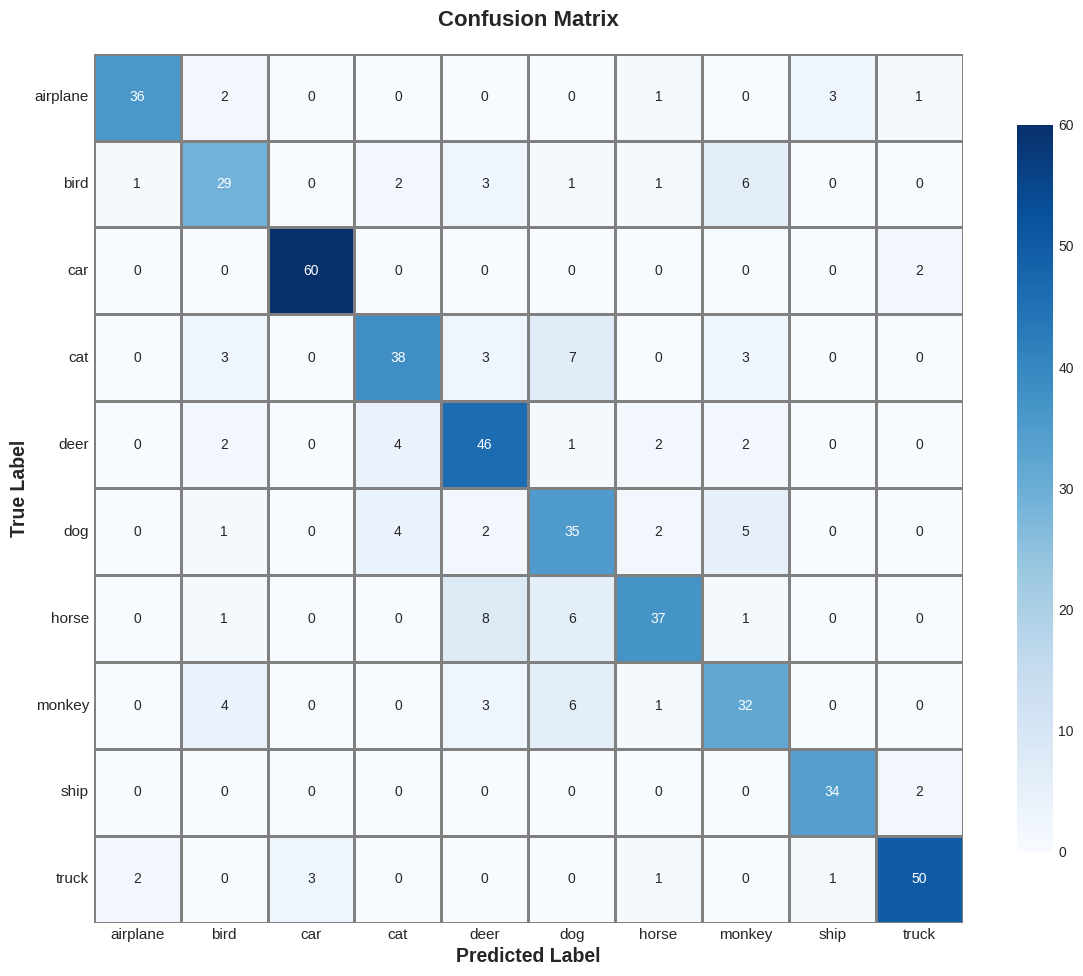


클래스별 정확도
 airplane : 0.8372 (83.72%) - 36/43개
   bird   : 0.6744 (67.44%) - 29/43개
   car    : 0.9677 (96.77%) - 60/62개
   cat    : 0.7037 (70.37%) - 38/54개
   deer   : 0.8070 (80.70%) - 46/57개
   dog    : 0.7143 (71.43%) - 35/49개
  horse   : 0.6981 (69.81%) - 37/53개
  monkey  : 0.6957 (69.57%) - 32/46개
   ship   : 0.9444 (94.44%) - 34/36개
  truck   : 0.8772 (87.72%) - 50/57개


In [102]:
def plot_confusion_matrix(true_labels, predicted_labels, class_names):
    """
    혼동 행렬 시각화 함수

    Args:
        true_labels: 실제 레이블 (list)
        predicted_labels: 예측 레이블 (list)
        class_names: 클래스 이름 리스트 (list)
    """
    # NumPy로 변환
    y_true = np.array(true_labels)
    y_pred = np.array(predicted_labels)

    # 혼동 행렬 계산
    cm = confusion_matrix(y_true, y_pred)

    # 시각화
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm,
        annot=True,           # 숫자 표시
        fmt='d',              # 정수 형식
        cmap='Blues',         # 색상
        square=True,          # 정사각형 셀
        cbar_kws={'shrink': 0.8},
        linewidths=1,
        linecolor='gray'
    )

    plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=14, fontweight='bold')
    plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)

    # 축 레이블 설정
    plt.xticks(np.arange(10) + 0.5, class_names, fontsize=11)
    plt.yticks(np.arange(10) + 0.5, class_names, fontsize=11, rotation=0)

    plt.tight_layout()
    plt.show()

    # 클래스별 정확도 출력
    print("\n" + "=" * 60)
    print("클래스별 정확도")
    print("=" * 60)
    for i in range(10):
        class_acc = cm[i, i] / cm[i].sum() if cm[i].sum() > 0 else 0
        print(f"{class_names[i]:^10}: {class_acc:.4f} ({class_acc*100:.2f}%) - {cm[i, i]}/{cm[i].sum()}개")
    print("=" * 60)

# 혼동 행렬 시각화
plot_confusion_matrix(test_labels, test_predictions, list(train_data.dataset.classes.values()))

In [103]:
def print_classification_report(true_labels, predicted_labels):
    """
    상세 성능 보고서 출력
    """
    y_true = true_labels
    y_pred = predicted_labels

    # Classification Report
    print("\n" + "=" * 70)
    print("상세 성능 보고서 (Classification Report)")
    print("=" * 70)
    print(classification_report(
        y_true,
        y_pred,
        target_names=[f'Digit {i}' for i in range(10)],
        digits=4
    ))

    # 전체 지표
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    print("=" * 70)
    print("전체 평균 지표 (Macro Average)")
    print("=" * 70)
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("=" * 70)

# 성능 보고서 출력
print_classification_report(test_labels, test_predictions)


상세 성능 보고서 (Classification Report)
              precision    recall  f1-score   support

     Digit 0     0.9231    0.8372    0.8780        43
     Digit 1     0.6905    0.6744    0.6824        43
     Digit 2     0.9524    0.9677    0.9600        62
     Digit 3     0.7917    0.7037    0.7451        54
     Digit 4     0.7077    0.8070    0.7541        57
     Digit 5     0.6250    0.7143    0.6667        49
     Digit 6     0.8222    0.6981    0.7551        53
     Digit 7     0.6531    0.6957    0.6737        46
     Digit 8     0.8947    0.9444    0.9189        36
     Digit 9     0.9091    0.8772    0.8929        57

    accuracy                         0.7940       500
   macro avg     0.7969    0.7920    0.7927       500
weighted avg     0.7996    0.7940    0.7950       500

전체 평균 지표 (Macro Average)
Precision: 0.7969
Recall: 0.7920
F1-Score: 0.7927


In [104]:
def get_all_images(loader):
    all_images = []
    for images, _ in loader:
        # 이미지를 CPU로 가져와서 리스트에 추가
        all_images.append(images.cpu())
    
    # 리스트를 하나의 텐서로 합침 (예: [Batch1, Batch2...] -> One Tensor)
    return torch.cat(all_images)

# 실행: X_test 생성
X_test = get_all_images(val_loader)
print(f"X_test shape: {X_test.shape}") 
# 예상 출력: torch.Size([8000, 3, 96, 96]) (데이터 개수에 따라 다름)

X_test shape: torch.Size([500, 3, 96, 96])


In [105]:
import matplotlib.pyplot as plt
import numpy as np

def analyze_misclassifications(true_labels, predicted_labels, test_data, dataset_classes, n_samples=10):
    """
    Args:
        true_labels: 정답 텐서
        predicted_labels: 예측 텐서
        test_data: 이미지 텐서 전체 (X_test)
        dataset_classes: 클래스 이름 리스트 (dataset.classes)
    """
    # 텐서 -> Numpy 변환
    y_true = np.array(true_labels)
    y_pred = np.array(predicted_labels)
    
    # 잘못 예측한 인덱스 찾기
    misclassified_indices = np.where(y_true != y_pred)[0]

    print(f"\n총 {len(misclassified_indices)}개의 샘플이 잘못 예측되었습니다.")
    print(f"오분류율: {len(misclassified_indices)/len(y_true)*100:.2f}%\n")

    if len(misclassified_indices) == 0:
        print("완벽한 예측! 잘못 예측한 샘플이 없습니다.")
        return

    # 랜덤 샘플 선택
    sample_size = min(n_samples, len(misclassified_indices))
    sample_indices = np.random.choice(misclassified_indices, sample_size, replace=False)

    # 시각화
    fig, axes = plt.subplots(2, 5, figsize=(15, 7))
    axes = axes.ravel()

    for i, idx in enumerate(sample_indices):
        # 1. 이미지 가져오기 (Tensor)
        img_tensor = test_data[idx] 
        
        # 2. 역정규화 (Un-normalize) : 학습 때 (0.5, 0.5)로 했다고 가정
        # 만약 transforms에서 normalize 값을 다르게 줬다면 그 값을 써야 함
        img_tensor = img_tensor * 0.5 + 0.5 
        
        # 3. 차원 변경 (C, H, W) -> (H, W, C) : matplotlib용
        img = img_tensor.permute(1, 2, 0).numpy()
        
        # 4. 값 클리핑 (0~1 사이로 안전하게 맞춤)
        img = np.clip(img, 0, 1)

        # 5. 라벨 이름 가져오기
        true_name = dataset_classes[y_true[idx]]
        pred_name = dataset_classes[y_pred[idx]]

        axes[i].imshow(img)
        axes[i].set_title(
            f'True: {true_name}\nPred: {pred_name}',
            fontsize=10,
            color='red',
            fontweight='bold'
        )
        axes[i].axis('off')

    plt.suptitle('Misclassified Samples Analysis', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()


총 103개의 샘플이 잘못 예측되었습니다.
오분류율: 20.60%



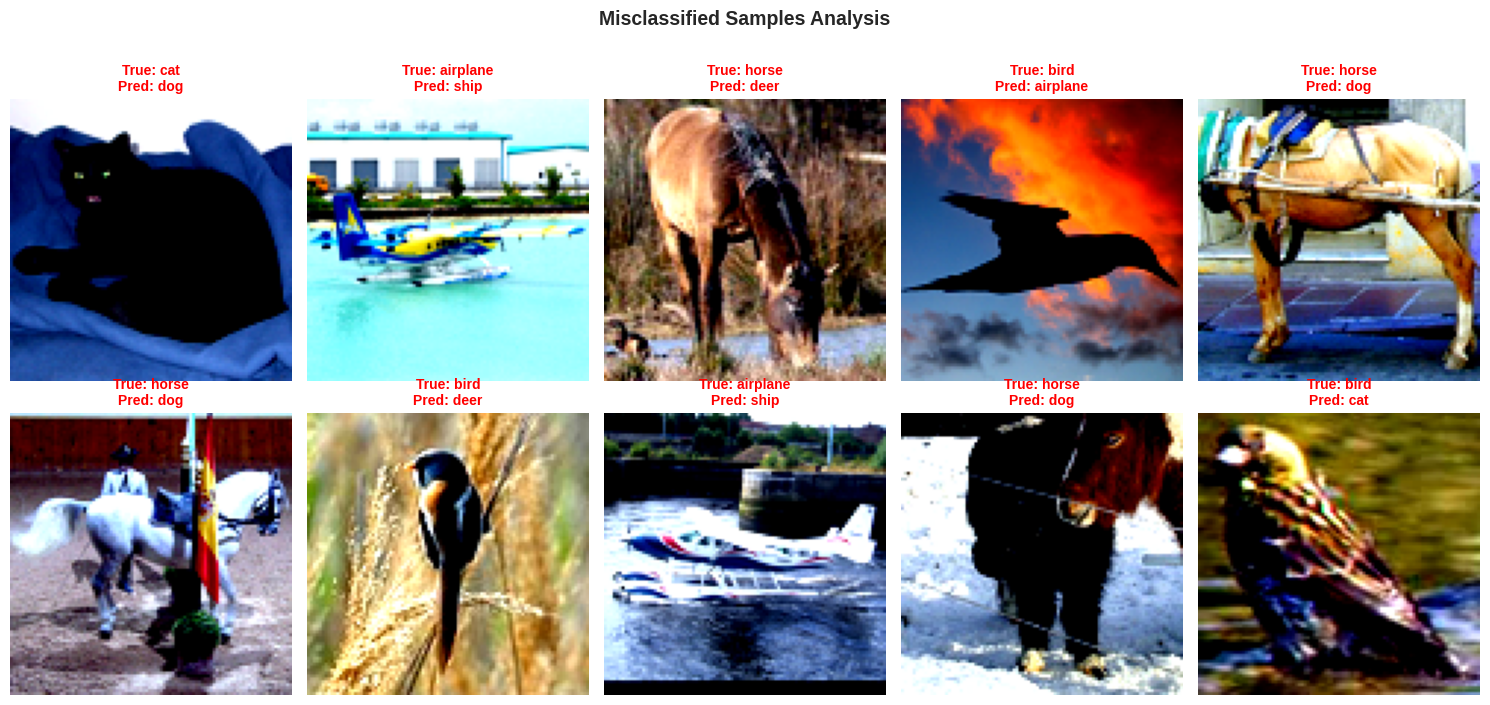

In [106]:
# 1. 평가 수행 (정답과 예측값 획득)
# evaluate 함수가 (loss, acc, preds, labels)를 리턴하도록 수정했었죠?
val_loss, val_acc, val_preds, val_labels = evaluate(model, val_loader, criterion, device)

# 2. 이미지 데이터 추출 (X_test 만들기)
X_test = get_all_images(val_loader)

# 3. 클래스 이름 준비 (딕셔너리 값만 리스트로)
# dataset.classes = {0: 'airplane', ...} 라고 가정
class_names = list(train_data.dataset.classes.values()) 

# 4. 오분류 분석 실행
analyze_misclassifications(val_labels, val_preds, X_test, class_names)

In [107]:
# def analyze_misclassifications(true_labels, predicted_labels, test_data, n_samples=10):
#     """
#     잘못 예측한 샘플 분석 및 시각화

#     Args:
#         true_labels: 실제 레이블
#         predicted_labels: 예측 레이블
#         test_data: 테스트 입력 데이터 (표준화 전)
#         n_samples: 표시할 샘플 수
#     """
#     y_true = true_labels.numpy()
#     y_pred = predicted_labels.numpy()

#     # 잘못 예측한 인덱스 찾기
#     misclassified_indices = np.where(y_true != y_pred)[0]

#     print(f"\n총 {len(misclassified_indices)}개의 샘플이 잘못 예측되었습니다.")
#     print(f"오분류율: {len(misclassified_indices)/len(y_true)*100:.2f}%\n")

#     if len(misclassified_indices) == 0:
#         print("완벽한 예측! 잘못 예측한 샘플이 없습니다.")
#         return

#     # 랜덤 샘플 선택
#     sample_size = min(n_samples, len(misclassified_indices))
#     sample_indices = np.random.choice(misclassified_indices, sample_size, replace=False)

#     # 시각화
#     fig, axes = plt.subplots(2, 5, figsize=(15, 6))
#     axes = axes.ravel()

#     for i, idx in enumerate(sample_indices):
#         # 이미지 데이터 복원 (8x8)
#         image = test_data[idx].reshape(8, 8)

#         axes[i].imshow(image, cmap='gray')
#         axes[i].set_title(
#             f'True: {y_true[idx]} | Pred: {y_pred[idx]}',
#             fontsize=11,
#             color='red',
#             fontweight='bold'
#         )
#         axes[i].axis('off')

#     plt.suptitle('Misclassified Samples', fontsize=14, fontweight='bold', y=1.02)
#     plt.tight_layout()
#     plt.show()

# # 오분류 샘플 분석
# analyze_misclassifications(test_labels, test_predictions, X_test)

In [108]:
# criterion = nn.CrossEntropyLoss() # 바꿔보기
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # 바꿔보기

# num_epochs = 100 # 바꿔보기

# total_step = len(train_loader)
# for epoch in range(num_epochs):
#     total_loss = 0

#     pbar = tqdm(enumerate(train_loader), total=len(train_loader))

#     for i, (images, labels) in pbar:
#         images = images.to(device)
#         labels = labels.to(device)

#         outputs = model(images)
#         loss = criterion(outputs, labels)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()

#         pbar.set_description(f'Epoch [{epoch+1}/{num_epochs}], Loss: {round(total_loss / (i+1),4)}')


#     model.eval()
#     with torch.no_grad():
#         correct = 0
#         total = 0
#         for images, labels in val_loader:
#             images = images.to(device)
#             labels = labels.to(device)
#             outputs = model(images)
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#         print(f'Accuracy of the model on the test images: {100 * correct / total} %')


# Evaluation (Test)

In [109]:
len(val_loader.dataset)
len(test_loader.dataset)

8000

In [110]:
correct = 0
total = len(val_loader.dataset)

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += torch.sum((predicted == labels)).item()

print(f'Accuracy : {100 * correct / total} %')


Accuracy : 79.4 %


# Make SubmitFile

In [111]:
# import pandas as pd

# # 제출 파일 submission.csv 생성
# outputs = {
#     'Id': [],
#     'Prediction': []
# }

# for images, id in tqdm(test_loader):
#     model.eval()
#     with torch.no_grad():
#         output = model(images.to(device))
#         _, predicted = torch.max(output, 1)
#         outputs['Prediction'] += predicted.tolist()
#         outputs['Id'] += id

# df = pd.DataFrame(outputs)

# df.to_csv('submission.csv', index=False, columns=['Id', 'Prediction'])

In [ ]:
# # 제출파일 다운로드
# from google.colab import files

# file_path = "submission.csv"
# files.download(file_path)

: 